# 耐久消費財の動学需要推定(J=2)

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interpn
import scipy.special as sp
from scipy.stats import norm
from scipy.optimize import minimize

## Main Model

In [157]:
class durable_goods_adoption_model():
    
    def __init__(self,
                 ngrid = 20,
                 n_min = 0.5,
                 n_max = 10,
                 nquad = 8,
                 rho = [-0.03,0.9,
                        -0.001,0.85],
                 sigma_psi = [0.4,0.4],
                 beta = [5,3],
                 alpha = -0.1,
                 delta = 0.99):
        
        self.ngrid = ngrid
        self.nquad = nquad
        self.rho = np.array(rho).reshape(2,2)
        self.sigma_psi = sigma_psi
        self.beta = beta
        self.alpha = alpha
        self.delta = delta
        self.grid = np.linspace(n_min,n_max,ngrid)
        self.quadrature_setup()

        

    
    def quadrature_setup(self):     
        self.node, self.weight = np.polynomial.hermite.hermgauss(self.nquad)
        self.node_price1, self.node_price2 = np.sqrt(2)*self.node*self.sigma_psi[0], np.sqrt(2)*self.node*self.sigma_psi[1]
        self.node = np.array(list(product(self.node_price1, self.node_price2)))
        # node = array([[node_1,node_1],
        #               [node_2,node_2],
        #               [.............],
        #               [node_nquad**2, n_nquad**2]])
        self.weight = np.array(list(product(self.weight/np.sqrt(np.pi), self.weight/np.sqrt(np.pi))))
        # weight = array([[weight_1,weight_1],
        #                 [weight_2,weight_2],
        #                 [.................],
        #                 [weight_nquad**2, weight_nquad**2]])
    
        
        
    def next_period_price(self,current_price1,current_price2):
        """
        current_price is assumed to be scaler(single value)
        """

        next_period_price1 = self.rho[0,0] + self.rho[0,1]*current_price1 + self.node[:,[0]] 
        next_period_price2 = self.rho[1,0] + self.rho[1,1]*current_price2 + self.node[:,[1]] 


              
        return next_period_price1,next_period_price2
                
      
    def interpolate_V0(self,V0,next_price1,next_price2):
        V0 = interpn((self.grid, self.grid),V0,(next_price1,next_price2),
                      method='linear',bounds_error=False,fill_value=None)
        
        return V0
            
    
    def calculate_CCP(self,V0):
        price1_mesh,price2_mesh = np.meshgrid(self.grid,self.grid)
        v1 = self.beta[0] + self.alpha*price1_mesh
        v2 = self.beta[1] + self.alpha*price2_mesh
        p0 = 1/(1+np.exp(v1-V0)+np.exp(v2-V0))
        p1 = np.exp(v1-V0)/(np.exp(V0-V0)+np.exp(v1-V0)+np.exp(v2-V0))
        p2 = 1 - p0 -p1
        
        return p0,p1,p2
 
    
    def bellman(self,V0):
        """Bellman operator""" 
        
        current_price1 = np.array(list(product(self.grid, self.grid)))[:,[0]].flatten()
        current_price2 = np.array(list(product(self.grid, self.grid)))[:,[1]].flatten()

        next_price1,next_price2 = self.next_period_price(current_price1,current_price2)
        # next_price is nquad**2 by ngrid**2 array
        v1 =self.beta[0] + self.alpha*next_price1
        v2 =self.beta[1] + self.alpha*next_price2 
        interpolated_V = self.interpolate_V0(V0,next_price1,next_price2)
        # now interpolated_V is nquad**2 by ngrid**2 array
        M = np.maximum(interpolated_V,np.maximum(v1,v2))
        weight = (self.weight[:,[0]]*self.weight[:,[1]]).flatten()
        V0 = self.delta*(weight[np.newaxis,:]@(M + np.log(np.exp(interpolated_V-M) + np.exp(v1-M) + np.exp(v2-M))))
        V0 = V0.reshape(self.ngrid,self.ngrid)
        price1_mesh,price2_mesh = np.meshgrid(self.grid,self.grid)
        v1 = self.beta[0] + self.alpha*price1_mesh
        v2 = self.beta[1] + self.alpha*price2_mesh    
        p0,p1,p2 = self.calculate_CCP(V0)
        
        return V0,v1,v2,p0,p1,p2
        
        
    def solve_vfi(self,maxiter=10000,tol=1e-8):
        V0 = np.zeros((self.ngrid,self.ngrid))
        for self.iter in range(maxiter):
            V1,v1,v2,p0,p1,p2 = self.bellman(V0)
            err = np.max(np.abs(V1-V0))
            if err < tol:
                break
            V0 = V1
        else:
            raise RuntimeError('No convergence: maximum number of iterations achieved!')
        return V0,v1,v2,p0,p1,p2
    
    
    def solve_plot(self):
        
        V0,V1,V2,p0,p1,p2 = self.solve_vfi()
        
        price1, price2 = np.meshgrid(self.grid, self.grid)
        
        fig_V0 = plt.figure(figsize=(8, 8))
        ax_V0 = fig_V0.add_subplot(111, projection='3d')
        z = V0.flatten()
        surf = ax_V0.plot_surface(price1, price2, z.reshape(V0.shape), cmap='viridis')
        ax_V0.set_xlabel('price 1')
        ax_V0.set_ylabel('price 2')
        ax_V0.set_zlabel('Value')
        fig_V0.colorbar(surf, ax=ax_V0, shrink=0.5, aspect=10)
        ax_V0.view_init(elev=30, azim=45)
        
        fig_V1 = plt.figure(figsize=(8, 8))
        ax_V1 = fig_V1.add_subplot(111, projection='3d')
        z1 = V1.flatten()
        surf = ax_V1.plot_surface(price1, price2, z1.reshape(V1.shape), cmap='viridis')
        ax_V1.set_xlabel('price 1')
        ax_V1.set_ylabel('price 2')
        ax_V1.set_zlabel('Value')
        fig_V1.colorbar(surf, ax=ax_V1, shrink=0.5, aspect=10)
        ax_V1.view_init(elev=20, azim=30)

        fig_V2 = plt.figure(figsize=(8, 8))
        ax_V2 = fig_V2.add_subplot(111, projection='3d')
        z2 = V2.flatten()
        surf = ax_V2.plot_surface(price1, price2, z2.reshape(V2.shape), cmap='viridis')
        ax_V2.set_xlabel('price 1')
        ax_V2.set_ylabel('price 2')
        ax_V2.set_zlabel('Value')
        fig_V2.colorbar(surf, ax=ax_V2, shrink=0.5, aspect=10)
        ax_V2.view_init(elev=20, azim=30)

        
        figp, (axp0,axp1,axp2) = plt.subplots(1,3,figsize=(14,8))
        axp0.set_title('choice prob 0')
        axp1.set_title('choice prob 1')
        axp2.set_title('choice prob 2')
        axp0.set_xlabel('price')
        axp1.set_xlabel('price 1')
        axp2.set_xlabel('price 2')
        axp0.set_ylabel('prob')
        axp1.set_ylabel('prob')
        axp2.set_ylabel('prob')
        axp0.plot(self.grid,np.diag(p0),color='k',alpha=0.25)
        axp1.plot(self.grid,p1[0,:],color='k',alpha=0.25)
        axp2.plot(self.grid,p2[:,0],color='k',alpha=0.25)
        
        plt.show()
        return V0,p0,p1,p2
    

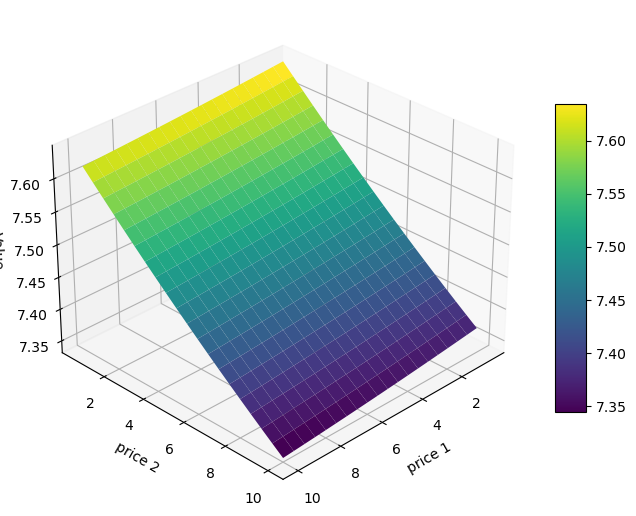

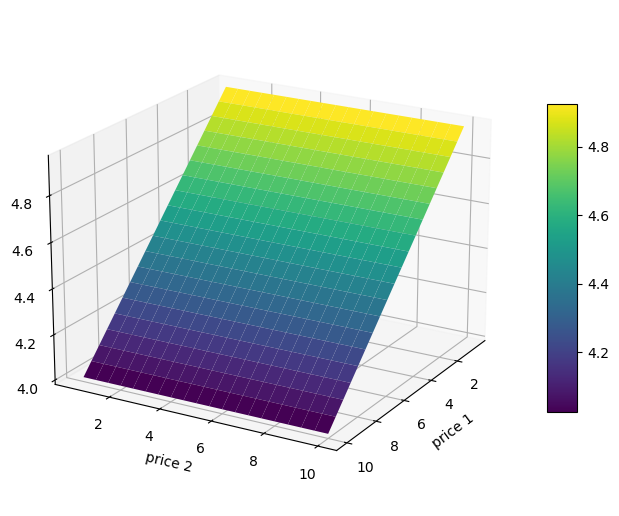

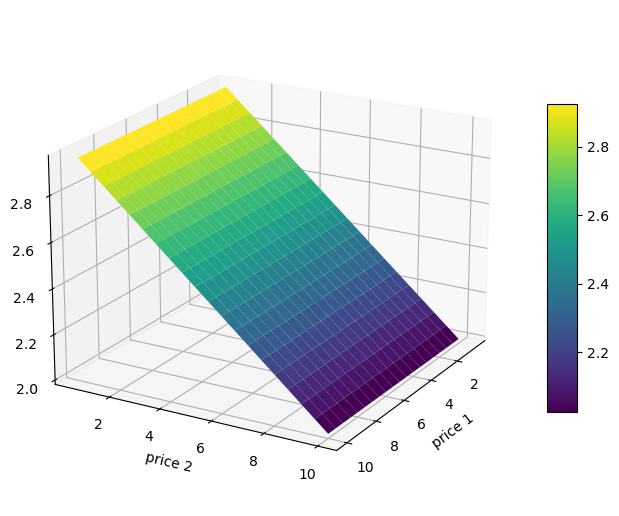

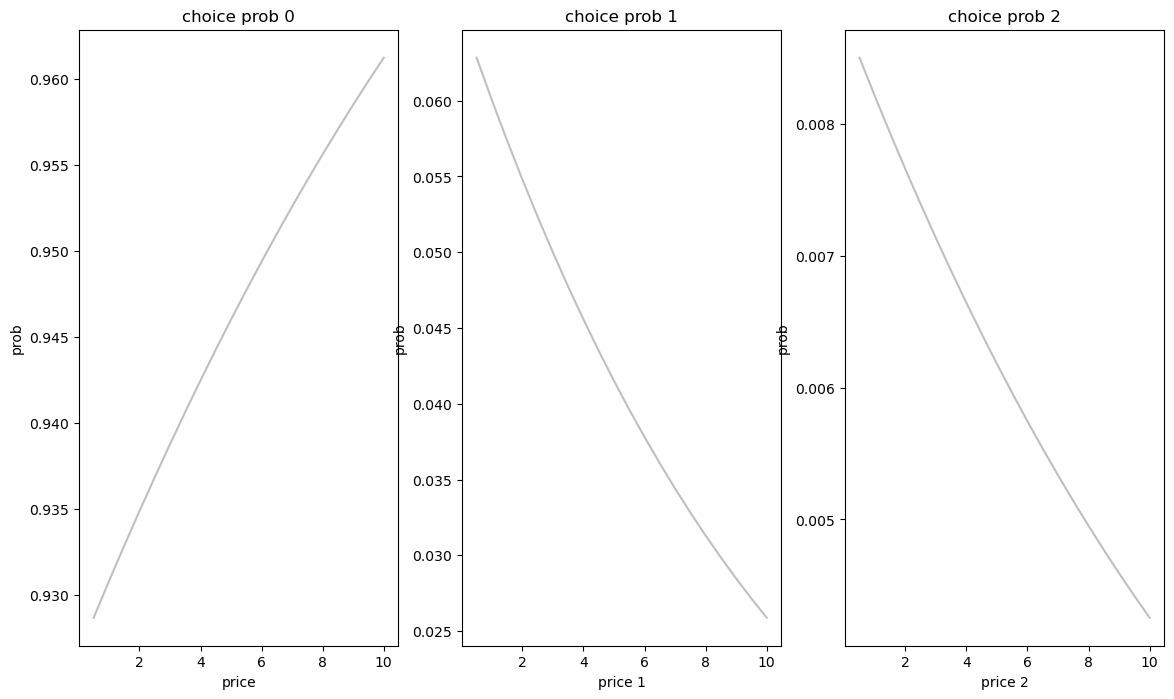

In [158]:
model = durable_goods_adoption_model()
V0,p0,p1,p2 = model.solve_plot()

## Price process simulation

In [159]:
def simulate_price_process(T = 10,
                           price_0 = [8,7.5],
                           rho = np.array([[-0.03,  0.9],[0.001,  0.8]]),
                           sigma_psi = np.array([0.4,0.4])):
    np.random.seed(1234)
    psi1 = np.random.normal(0,sigma_psi[0],size = T)
    psi2 = np.random.normal(0,sigma_psi[1],size = T)
    psi = np.array([psi1,psi2]).T
    price = np.zeros((T,2))
    price[0,:] = np.array(price_0)
    for t in range(1,T):
        price[t,:] = rho[:,[0]].flatten() + rho[:,[1]].flatten()*price[t-1,:] + psi[t,:]
    
    return price

simulate_price_process()

array([[8.        , 7.5       ],
       [6.69360972, 6.39777841],
       [6.56733154, 5.50055238],
       [5.75553763, 3.59293997],
       [4.86174837, 2.74172103],
       [4.70043871, 2.19522417],
       [4.5442302 , 1.9193607 ],
       [3.80519778, 1.65212534],
       [3.40095655, 1.85116355],
       [2.13378691, 0.86316862]])

## Data simulation

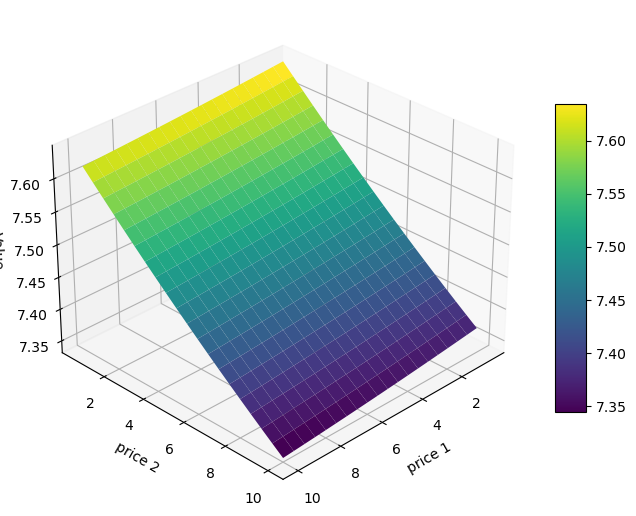

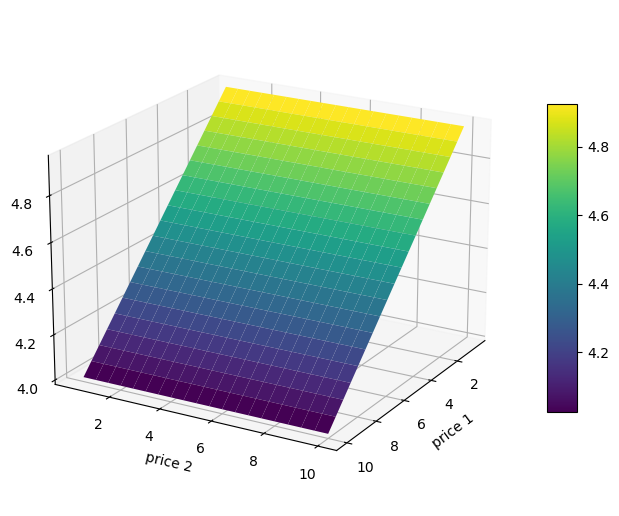

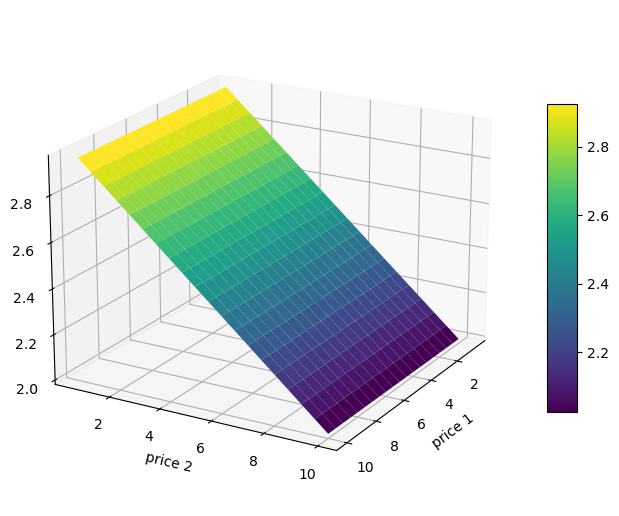

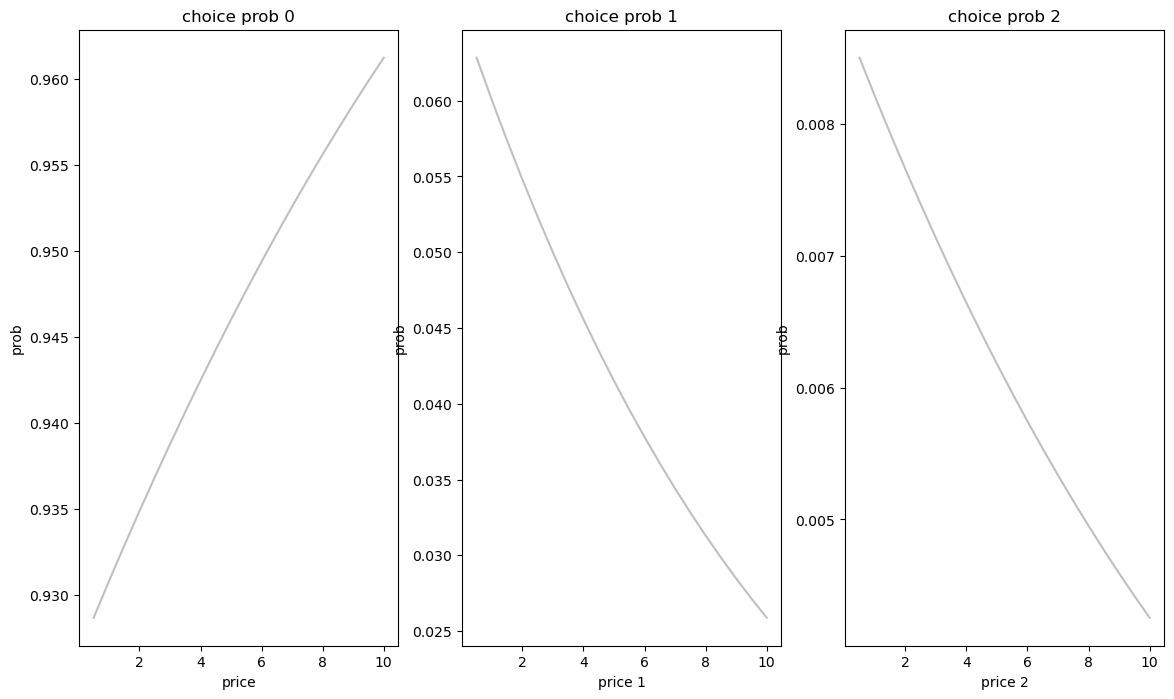

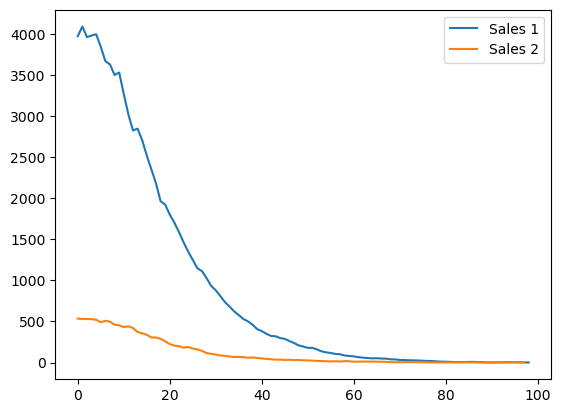

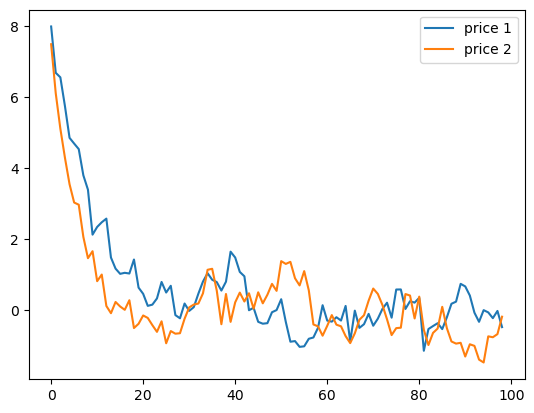

CPU times: total: 19min 9s
Wall time: 28min 10s


,i,t,decision,state1,state2,state1_previous,state2_previous
0,0.0,0.0,0.0,8.000000,7.500000,NaN,NaN
1,0.0,1.0,0.0,6.693610,6.600613,8.000000,7.500000
2,0.0,2.0,0.0,6.567332,5.810958,6.693610,6.600613
3,0.0,3.0,0.0,5.755538,5.052433,6.567332,5.810958
4,0.0,4.0,0.0,4.861748,4.487283,5.755538,5.052433
...,...,...,...,...,...,...,...
1580725,99997.0,1.0,0.0,6.693610,6.600613,8.000000,7.500000
1580726,99997.0,2.0,1.0,6.567332,5.810958,6.693610,6.600613
1580727,99998.0,0.0,0.0,8.000000,7.500000,NaN,NaN
1580728,99998.0,1.0,1.0,6.693610,6.600613,8.000000,7.500000


In [160]:
%%time
def simulate_purchase_decision(T = 100,
                               N_consumer = 100000,
                               price_0 = [8,7.5],
                               model = model):
    
    
    beta = np.array(model.beta)
    alpha = model.alpha
    price = simulate_price_process(T,price_0,rho = model.rho,sigma_psi = model.sigma_psi)
    V0,_,_,_ = model.solve_plot()
    data_array = np.array([[],[],[],[],[]])
    
    for i in range(N_consumer):
        idx_consumer = []
        time = []
        decision_i = []
        price1_i = []
        price2_i = []
        for t in range(T):
            idx_consumer.append(i)
            time.append(t)
            np.random.seed(i+t)
            epsilon = sp.digamma(1)-np.log(-np.log(np.random.rand(3)))
            v0 = model.interpolate_V0(V0,price[t,0],price[t,1]) + epsilon[0]
            v1 = beta[0] + alpha*price[t,0] + epsilon[1]
            v2 = beta[1] + alpha*price[t,1] + epsilon[2]
            values = {'v0':v0,'v1':v1,'v2':v2}
            maximum_value = max(values,key=values.get)
            decision = 0 if maximum_value == 'v0' else (1 if maximum_value == 'v1' else 2)
            decision_i.append(decision)
            price1_i.append(price[t,0])
            price2_i.append(price[t,1])
            if decision != 0:
                  break
        data_i = np.array([idx_consumer,time,decision_i,price1_i,price2_i])
        data_array = np.hstack((data_array,data_i))
    
    data = pd.DataFrame(np.transpose(data_array),columns=["i","t","decision","state1","state2"])
    
    
    plt.plot(data["decision"][data.decision==1].groupby(data["t"]).count(),label = "Sales 1")
    plt.plot(data["decision"][data.decision==2].groupby(data["t"]).count(),label = "Sales 2")
    plt.legend()
    plt.show()
    plt.plot(simulate_price_process(T=len(np.unique(data["t"])))[:,0],label ="price 1")
    plt.plot(simulate_price_process(T=len(np.unique(data["t"])))[:,1],label ="price 2")
    plt.legend()
    plt.show()
        
    pre_state1 = (data.state1.groupby(data.t).unique().shift(1)).apply(lambda x: float(str(x[0])) if pd.notna(x) else None)

    pre_state2 = (data.state2.groupby(data.t).unique().shift(1)).apply(lambda x: float(str(x[0])) if pd.notna(x) else None)


    data = pd.merge(data, pd.concat([pre_state1, pre_state2], axis=1), how ='left', on='t', suffixes=( '','_previous'))
    
    
    return data
data = simulate_purchase_decision()
data

## Estimation

In [161]:
def log_likelihood(theta,data=data):
    model = durable_goods_adoption_model(beta = [theta[0],theta[1]],
                                         alpha = theta[2],
                                         rho = [theta[3],theta[4],theta[5],theta[6]],
                                         sigma_psi = [theta[7],theta[8]])
    V,_,_,_,_,_ = model.solve_vfi()
    beta = [theta[0],theta[1]]
    alpha = theta[2]    
    rho = [theta[3],theta[4],theta[5],theta[6]]
    sigma_psi = [theta[7],theta[8]]
        
    Log_lik = 0
    
    data = data[data.t != 0]
    
    # no purchase
    V0_decision0 = model.interpolate_V0(V,data.state1[data.decision==0],data.state2[data.decision==0])
    V1_decision0 = beta[0] + alpha*data.state1[data.decision==0]
    V2_decision0 = beta[1] + alpha*data.state2[data.decision==0]
    p0 = 1/(1+np.exp(V1_decision0-V0_decision0)+np.exp(V2_decision0-V0_decision0))
    
    state_pred1 = rho[0] + rho[1]*data.state1_previous[data.decision==0]
    state_pred2 = rho[2] + rho[3]*data.state2_previous[data.decision==0]
    psi1 = data.state1[data.decision==0] - state_pred1
    psi2 = data.state2[data.decision==0] - state_pred2
    f_psi1 = norm(0,sigma_psi[0]).pdf(np.array(psi1))
    f_psi2 = norm(0,sigma_psi[1]).pdf(np.array(psi2))
              
    Log_lik += np.sum(np.log(p0+1e-10)+ np.log(f_psi1+1e-10) + np.log(f_psi2+1e-10))
    
    # purchase good 1   
    V0_decision1 = model.interpolate_V0(V,data.state1[data.decision==1],data.state2[data.decision==1])
    V1_decision1 = beta[0] + alpha*data.state1[data.decision==1]
    V2_decision1 = beta[1] + alpha*data.state2[data.decision==1]
    p1 = np.exp(V1_decision1-V0_decision1)/(1+np.exp(V1_decision1-V0_decision1)+np.exp(V2_decision1-V0_decision1))
    
    state_pred1 = rho[0] + rho[1]*data.state1_previous[data.decision==1]
    state_pred2 = rho[2] + rho[3]*data.state2_previous[data.decision==1]
    psi1 = data.state1[data.decision==1] - state_pred1
    psi2 = data.state2[data.decision==1] - state_pred2
    f_psi1 = norm(0,sigma_psi[0]).pdf(np.array(psi1))
    f_psi2 = norm(0,sigma_psi[1]).pdf(np.array(psi2))
    
    Log_lik += np.sum(np.log(p1+1e-10)+np.log(f_psi1+1e-10) + np.log(f_psi2+1e-10))
       
    # purchase good 2
    V0_decision2 = model.interpolate_V0(V,data.state1[data.decision==2],data.state2[data.decision==2])
    V1_decision2 = beta[0] + alpha*data.state1[data.decision==2]
    V2_decision2 = beta[1] + alpha*data.state2[data.decision==2]
    p2 = np.exp(V2_decision2-V0_decision2)/(1+np.exp(V1_decision2-V0_decision2)+np.exp(V2_decision2-V0_decision2))
    
    state_pred1 = rho[0] + rho[1]*data.state1_previous[data.decision==2]
    state_pred2 = rho[2] + rho[3]*data.state2_previous[data.decision==2]
    psi1 = data.state1[data.decision==2] - state_pred1
    psi2 = data.state2[data.decision==2] - state_pred2
    f_psi1 = norm(0,sigma_psi[0]).pdf(np.array(psi1))
    f_psi2 = norm(0,sigma_psi[1]).pdf(np.array(psi2))
                
    Log_lik += np.sum(np.log(p2+1e-10)+np.log(f_psi1+1e-10)+ np.log(f_psi2+1e-10))
 
    
    return -Log_lik

theta_true = [model.beta[0],model.beta[1],model.alpha,
              model.rho[0,0],model.rho[0,1],model.rho[1,0],model.rho[1,1],
              model.sigma_psi[0],model.sigma_psi[1]]
log_likelihood(theta=theta_true,data=data)

1771862.3694546195

In [179]:
%%time
np.random.seed(12345)
bounds = [(0, 100), (0, 100),(-100, 0),(-10, 10),(0.01,1),(-10, 10),(0.01,1),(0.01, 1),(0.01, 1)] 
theta_init = (np.random.uniform(0,10),np.random.uniform(0,10),np.random.uniform(-10,0),
              np.random.uniform(-10,10),np.random.uniform(0,1),np.random.uniform(-10,10),np.random.uniform(0,1),
              np.random.uniform(0.01,1),np.random.uniform(0.01,1))
result = minimize(log_likelihood, x0=theta_init,
                        args=(data),
                        method='L-BFGS-B',
                        bounds=bounds)
θ_star = result.x
print(θ_star)

[ 5.27135384  3.17586457 -0.10971982  0.03625491  0.87942821 -0.05569086
  0.88159419  0.41094875  0.34445773]
CPU times: total: 9min 34s
Wall time: 31min 50s


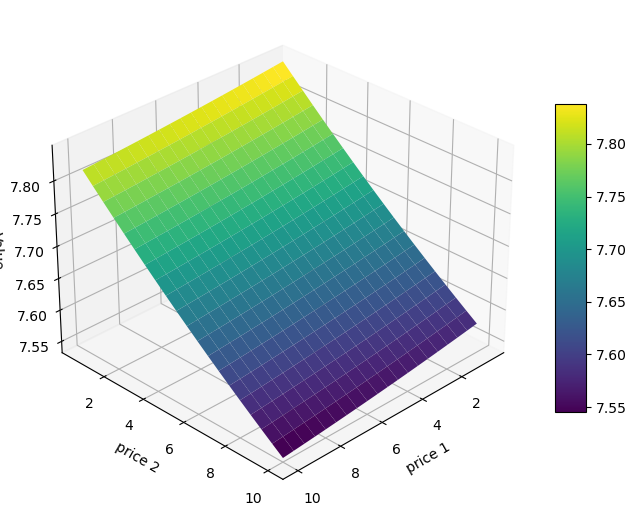

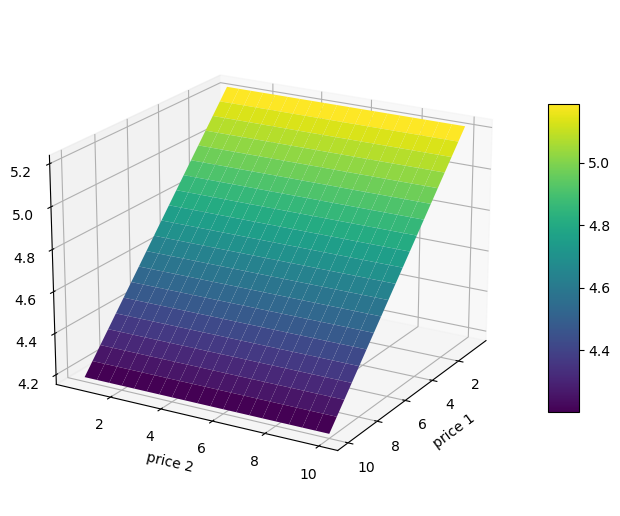

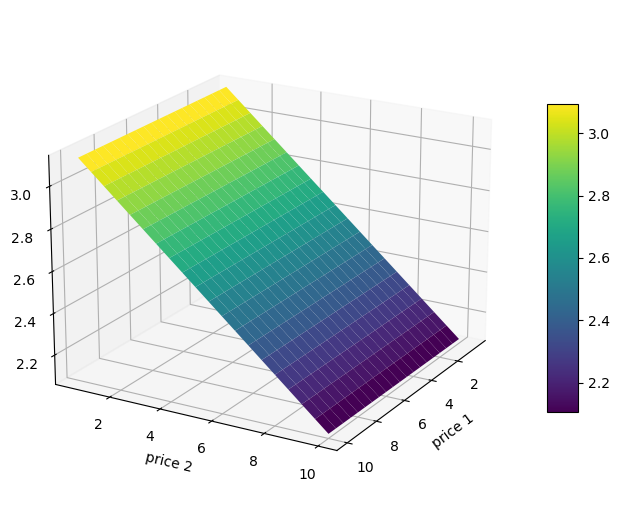

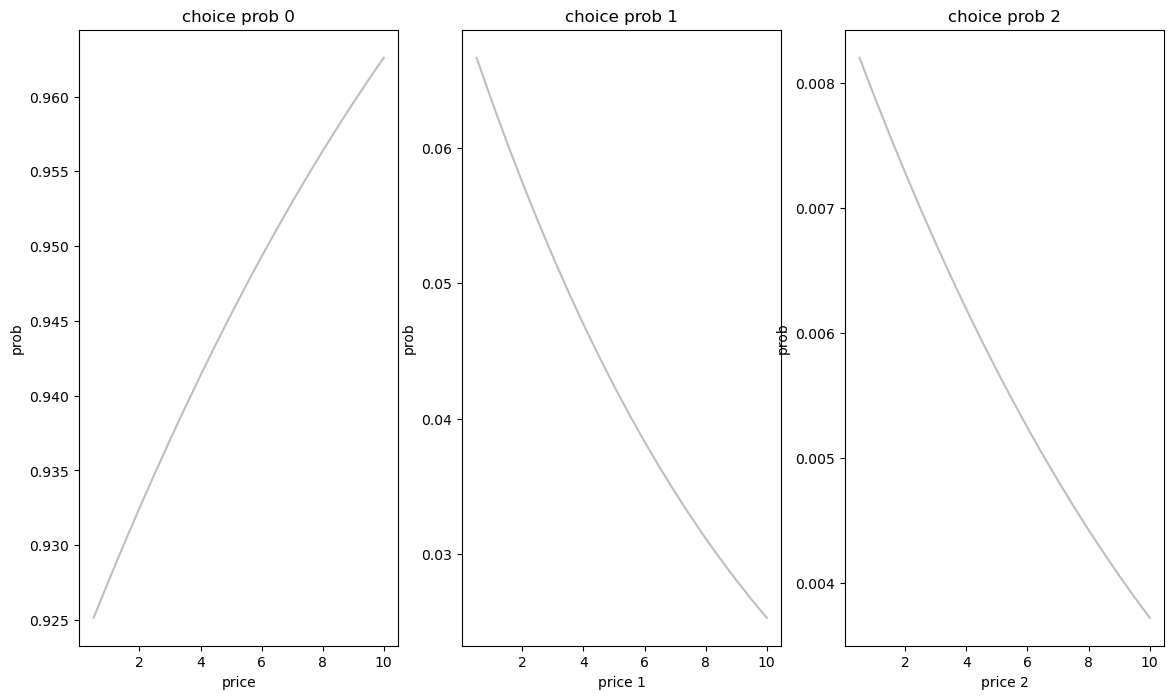

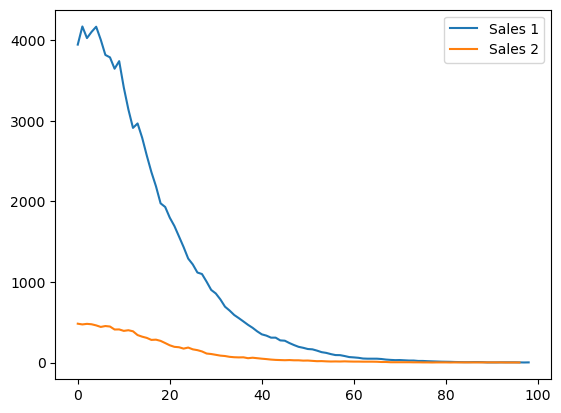

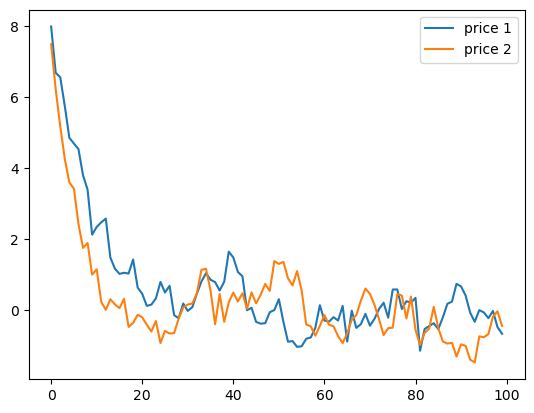

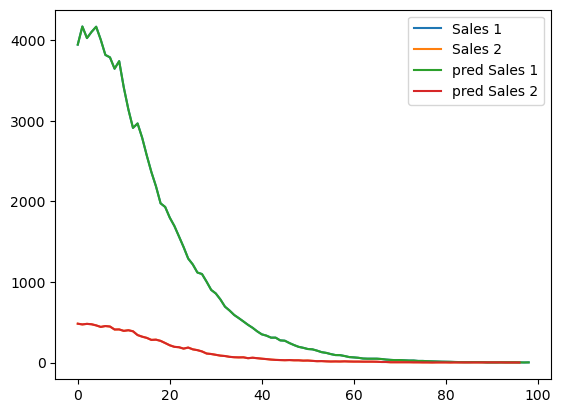

In [183]:
model_pred = durable_goods_adoption_model(beta = [θ_star[0],θ_star[1]],
                                          alpha = θ_star[2],
                                         rho = [θ_star[3],θ_star[4],θ_star[5],θ_star[6]],
                                         sigma_psi = [θ_star[7],θ_star[8]])
data_pred = simulate_purchase_decision(model=model_pred)
plt.plot(data_pred["decision"][data_pred.decision==1].groupby(data_pred["t"]).count(),label = "Sales 1")
plt.plot(data_pred["decision"][data_pred.decision==2].groupby(data_pred["t"]).count(),label = "Sales 2")
plt.plot(data_pred["decision"][data_pred.decision==1].groupby(data_pred["t"]).count(),label = "pred Sales 1")
plt.plot(data_pred["decision"][data_pred.decision==2].groupby(data_pred["t"]).count(),label = "pred Sales 2")
plt.legend()
plt.show()